# Exploratory Data Analysis & Building Machine Learning Data Table
# _Factors affecting vessel delays at US Army Corps of Engineers-managed locks on US waterways._

## Springboard Data Science Career Track, Capstone 2
***
* Author: Heather A. Passmore
* Data: United States Army Corps of Engineers, Lock Performance Management System
* Capstone Description: [Project Proposal](https://github.com/PassMoreHeat/springboard/blob/master/Capstone_2/ProjectProposalCap2.md)
* Initial Data Approach: [Data Wrangling Report](https://github.com/PassMoreHeat/springboard/blob/master/Capstone_2/Data_Wrangling_Report.md)
* Milestone Report
* Final Report
***
## Table of Contents
1. Import Dataframes from Previous Step & Calculate 75th percentile delay per lock
2. Apply Defined Delay Per Lock to Each Vessel Record (row) 
3. Explore patterns of delay per EROC, River, Lockage, Lock
4. Assign Delay Cateogories HIGH or LOW to Individual Locks Based on Proportion of Delays
5. Explore Patterns in Delay Count by Year, Month, Day for Vessels
6. Examine Delays Per Lock & Per Day
7. Add Stall Stoppage information to Main Traffic Delay Dataframe
8. Start to Build Focal DataFrame for Machine Learning
9. Delete unneccesary columns, create full and reduced datasets for ML

## 1. Import Dataframes from Previous Step & Calculate 75th percentile delay per lock

In [1]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
import pickle
import scipy.stats
from scipy.stats import norm
import scipy as sp

# Figures inline, visualization style
%matplotlib inline

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

In [2]:
# Bring traf_sample_updated dataframe into workspace: random sample plus some calculated columns
# load the pickled traf_sample_updated DataFrame from hard drive in 'rb' mode
with open('/Users/pgagnon/Documents/Springboard/springboard/Capstone_2/LockData/traf_sample_updated.pickle','rb') as f:
    traf_sample_updated = pickle.load(f)

In [3]:
# Bring no_zero_delay dataframe into workspace
# load the pickled no_zero_delay DataFrame from hard drive in 'rb' mode
with open('/Users/pgagnon/Documents/Springboard/springboard/Capstone_2/LockData/no_zero_delay.pickle','rb') as f:
    no_zero_delay = pickle.load(f)

In [4]:
# Bring stall_stop_13_17 dataframe into workspace
# load the pickled stall_stop_13_17 DataFrame from hard drive in 'rb' mode
with open('/Users/pgagnon/Documents/Springboard/springboard/Capstone_2/LockData/stall_stop_2013_2017.pickle','rb') as f:
    stall_stop_13_17 = pickle.load(f)

In [5]:
# Read rivermstr csv for river_names
rivermstr = pd.read_csv('/Users/pgagnon/Documents/Springboard/springboard/Capstone_2/LockData/RIVERMSTR.csv', 
                    index_col=None, header = 0)

In [6]:
# check columns of traf_sample_updated
traf_sample_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392000 entries, 2093451 to 488481
Data columns (total 27 columns):
EROC                    392000 non-null object
RIVER_CODE              392000 non-null object
LOCK_NO                 392000 non-null int64
CHMBR_NO                392000 non-null int64
OPS_ID                  392000 non-null object
LOCKAGE_TYPE            392000 non-null object
VESSEL_NO               392000 non-null int64
VESSEL_FUNCTION_TYPE    390657 non-null object
FLOTILLA_NO             269205 non-null object
ARRIVAL_DATE            392000 non-null datetime64[ns]
SOL_DATE                392000 non-null datetime64[ns]
BOW_OVER_SILL           281505 non-null datetime64[ns]
END_OF_ENTRY            281518 non-null datetime64[ns]
START_OF_EXIT           281561 non-null datetime64[ns]
END_OF_LOCKAGE          392000 non-null datetime64[ns]
NUM_CMRCL_PASSGRS       54260 non-null float64
ASST_CODE               27485 non-null object
SIGNAL_DATE             813 non-null dat

In [7]:
# Create a single-column unique identifier for individual locks in no_zero_delay: E_R_L
no_zero_delay['E_R_L'] = no_zero_delay['EROC'] + '_' + no_zero_delay['RIVER_CODE'] + '_' + no_zero_delay['LOCK_NO'].astype(str)

In [8]:
# define 25th and 75th percentile funcitons and apply with pivot_table
def my25(g):
    return np.percentile(g, 25)

def my75(g):
    return np.percentile(g, 75)

In [9]:
# use defined function for 75 percentile of non-zero delay_time
lock_prctle = no_zero_delay.pivot_table(columns='E_R_L', values='delay_time', aggfunc= [my75])

# convert to dataframe and transpose
lock75th = pd.DataFrame(lock_prctle).T

In [10]:
# reset the multiindex and remove the my75 index (now 'level_0)
lock_delay = lock75th.reset_index()
lock_delay.drop(labels='level_0', axis='columns', inplace=True)
lock_delay.head()

,E_R_L,delay_time
0,B2_AT_11,1.0
1,B2_CA_23,1.0
2,B2_FB_41,11.0
3,B2_GI_1,298.0
4,B2_GI_2,143.0


In [11]:
# The 75th percentile of delay_time per lock. Sorted by longest. This is the definition of delay per lock
lock_delay.sort_values(by=['delay_time'], ascending=False, inplace=True)
lock_delay.rename(columns={'E_R_L': 'E_R_L', 'delay_time': 'pct75_delay_time'}, inplace=True)
lock_delay.head(15)

,E_R_L,pct75_delay_time
87,H2_OH_52,1754.50
7,B2_GI_3,1574.50
140,K5_AL_13,1081.25
97,H3_TN_1,855.00
133,K3_CN_21,676.00
142,K5_AP_23,633.00
160,K7_FR_2,590.00
8,B2_GI_4,470.00
35,B5_IL_8,346.00
74,H1_KA_1,336.75


## 2. Apply Defined Delay Per Lock to Each Vessel Record (row)

In [12]:
# Define Delay: Based on the 75th percentile delay_time for individual locks
# First, use pd.merge to add the 75th percentile value into a column
traf_sample_delay = pd.merge(traf_sample_updated, lock_delay, how='left', left_on='E_R_L', right_on='E_R_L')
traf_sample_delay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392000 entries, 0 to 391999
Data columns (total 28 columns):
EROC                    392000 non-null object
RIVER_CODE              392000 non-null object
LOCK_NO                 392000 non-null int64
CHMBR_NO                392000 non-null int64
OPS_ID                  392000 non-null object
LOCKAGE_TYPE            392000 non-null object
VESSEL_NO               392000 non-null int64
VESSEL_FUNCTION_TYPE    390657 non-null object
FLOTILLA_NO             269205 non-null object
ARRIVAL_DATE            392000 non-null datetime64[ns]
SOL_DATE                392000 non-null datetime64[ns]
BOW_OVER_SILL           281505 non-null datetime64[ns]
END_OF_ENTRY            281518 non-null datetime64[ns]
START_OF_EXIT           281561 non-null datetime64[ns]
END_OF_LOCKAGE          392000 non-null datetime64[ns]
NUM_CMRCL_PASSGRS       54260 non-null float64
ASST_CODE               27485 non-null object
SIGNAL_DATE             813 non-null datetime6

In [13]:
# Assign bool True to 'delay' when 'delay_time' value > 'pct75_delay_time' value
traf_sample_delay['delay'] = np.where(traf_sample_delay['delay_time'] > traf_sample_delay['pct75_delay_time'], True, False)

In [14]:
# Look at dataframe
traf_sample_delay.head(10)

,EROC,RIVER_CODE,LOCK_NO,CHMBR_NO,OPS_ID,LOCKAGE_TYPE,VESSEL_NO,VESSEL_FUNCTION_TYPE,FLOTILLA_NO,ARRIVAL_DATE,...,DEPARTURE_DATE,LINE_SEQ_NO,entry_time,exit_time,delay_time,delay,E_R_L,YYMMDD,hhmmss,pct75_delay_time
0,H2,OH,75,2,L5608584,S,2246973225,T,L3435504,2014-05-07 05:37:00,...,NaT,821558,10.0,14.0,10.0,False,H2_OH_75,2014-05-07,05:37:00,146.0
1,M5,MK,22,1,L7532719,C,967995540,T,L4611089,2017-04-06 00:40:00,...,NaT,912730,30.0,8.0,0.0,False,M5_MK_22,2017-04-06,00:40:00,105.0
2,M3,GI,14,1,L6150873,O,3171419219,T,L3767838,2015-02-10 20:00:00,...,NaT,838438,NaN,NaN,66.0,False,M3_GI_14,2015-02-10,20:00:00,197.0
3,H4,MN,25,1,L6581479,S,2064406338,T,L4017674,2015-09-20 02:20:00,...,NaT,362970,10.0,5.0,20.0,False,H4_MN_25,2015-09-20,02:20:00,39.0
4,M3,GI,13,1,L7255211,O,1088709797,T,L4420842,2016-10-01 01:08:00,...,NaT,810510,NaN,NaN,67.0,False,M3_GI_13,2016-10-01,01:08:00,216.0
5,H4,OH,71,1,L6225825,S,1078394486,T,L3821128,2015-04-06 19:24:00,...,NaT,135181,14.0,10.0,7.0,False,H4_OH_71,2015-04-06,19:24:00,106.0
6,B5,MI,15,1,L4892914,S,801227182,T,L2984572,2013-04-02 03:55:00,...,NaT,162898,20.0,20.0,0.0,False,B5_MI_15,2013-04-02,03:55:00,213.0
7,B4,RR,41,1,L7487782,S,3919924767,G,NaN,2017-03-09 15:15:00,...,NaT,729023,5.0,5.0,0.0,False,B4_RR_41,2017-03-09,15:15:00,19.0
8,B2,GI,1,1,L7836405,S,356322780,T,L4779114,2017-09-01 11:20:00,...,NaT,981839,5.0,8.0,91.0,False,B2_GI_1,2017-09-01,11:20:00,298.0
9,B2,GI,77,1,L5076031,S,2188274291,T,L3092988,2013-07-05 22:45:00,...,NaT,814563,4.0,8.0,35.0,False,B2_GI_77,2013-07-05,22:45:00,75.0


## 3. Explore patterns of delay per EROC, River, Lockage, Lock

In [15]:
# count number of delays
traf_sample_delay['delay'].value_counts()

False    333264
True      58736
Name: delay, dtype: int64

In [16]:
# calculate percent of lock delays
no_delay = traf_sample_delay['delay'].value_counts()[0] # first value of the result above
delays = traf_sample_delay['delay'].value_counts()[1] # second value of the result above
total_lockage = no_delay + delays # total count of lockage events
print('Overall proportion of vessels delayed', float(delays) / total_lockage) # converting to float to get a float result

Overall proportion of vessels delayed 0.149836734694


In [17]:
# groupby EROC to see counts by Engineer Reporting Office Code (Corps division & district)
group_by_EROC = traf_sample_delay.groupby(['EROC','delay'])

In [18]:
# group categories by size and unstack by EROC
count_delays_by_eroc = group_by_EROC.size().unstack()

In [19]:
# calculate proportion of lockage events that are 'delays' by EROC
prop_by_EROC = pd.DataFrame(traf_sample_delay.groupby('EROC')['delay'].apply(lambda x: np.sum(x)/len(x)))

In [20]:
# Join count_delays_by_eroc with prop_by_EROC
count_prop_EROC = count_delays_by_eroc.join(prop_by_EROC)
count_prop_EROC

,False,True,delay
EROC,,,
B2,50767,15211,0.230547
B3,11923,2782,0.189187
B4,4427,334,0.070153
B5,38996,8591,0.180532
B6,20837,2747,0.116477
E3,1523,17,0.011039
E4,2967,470,0.136747
G2,3011,731,0.195350
G3,7370,1882,0.203415


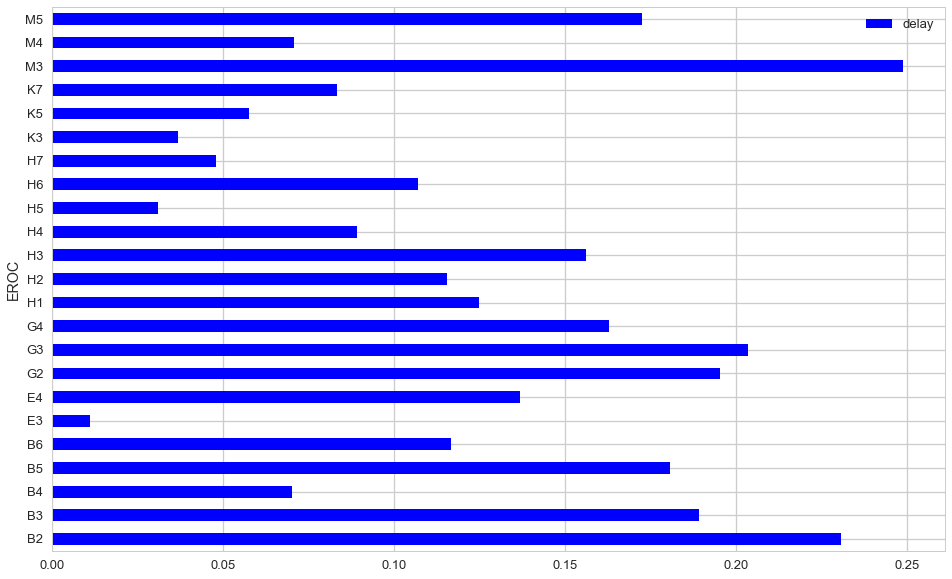

In [21]:
# Plot proportion delayed by EROC
count_prop_EROC.plot(y='delay', use_index=True, kind='barh', figsize=[16,10], colormap='winter')

In [22]:
# groupby River_Code to get counts by River
group_by_river = traf_sample_delay.groupby(['RIVER_CODE','delay'])

In [23]:
# view categories by size and unstack by RIVER_CODE
count_delays_by_river = group_by_river.size().unstack()

In [24]:
# calculate proportion of lockage events by river that are 'delays' (>110min)
prop_by_river = pd.DataFrame(traf_sample_delay.groupby('RIVER_CODE')['delay'].apply(lambda x: np.sum(x)/len(x)))

In [25]:
# set index of rivermstr to river_code
rivers = rivermstr.set_index('RIVER_CODE')

# Join rivers with count_delays_by_river to provide river names
delays_rivername = rivers.join(count_delays_by_river)

# Join delays_rivername with prop_by_river, view highest proportion of delays first
count_prop_river = delays_rivername.join(prop_by_river)
count_prop_river.sort_values(by=['delay'], ascending=False, inplace=True, )
count_prop_river

,RIVER_NAME,False,True,delay
RIVER_CODE,,,,
OD,OLD RIVER,1612.0,535.0,0.249185
GI,GULF INTRACOASTAL WATERWAY,63052.0,20441.0,0.244823
FB,FRESHWATER BAYOU,6050.0,1813.0,0.230574
WS,LAKE WASHINGTON SHIP CANAL,7370.0,1882.0,0.203415
AT,ATCHAFALAYA RIVER,1505.0,375.0,0.199468
CO,COLUMBIA RIVER,3823.0,944.0,0.198028
MI,MISSISSIPPI RIVER,54343.0,11308.0,0.172244
TN,TENNESSEE RIVER,11259.0,2266.0,0.167542
IL,ILLINOIS WATERWAY,16661.0,2811.0,0.144361


In [26]:
# groupby LOCKAGE_TYPE to see counts by LOCKAGE_TYPE
group_by_LOCKAGE = traf_sample_delay.groupby(['LOCKAGE_TYPE','delay'])

In [27]:
# view categories by size and unstack by LOCKAGE_TYPE
# A = Barges After Tow, B = Barges Before Tow, C = Consecutive, F = Fast Double
# J = Jacknife, K = Knockout, N = Navigable Pass, O = Open Pass, S = Straight
# T = Barge Transfer, V = Setover, Z = other
count_delays_by_lockage = group_by_LOCKAGE.size().unstack()

In [28]:
# calculate percent of lockage events that are 'delays' (>110min)
prop_by_lockage = pd.DataFrame(traf_sample_delay.groupby('LOCKAGE_TYPE')['delay'].apply(lambda x: np.sum(x)/len(x)))

# Join count_delays_by_lockage with prop_by_lockage
count_prop_lockage = count_delays_by_lockage.join(prop_by_lockage)
count_prop_lockage

,False,True,delay
LOCKAGE_TYPE,,,
A,9,3,0.250000
B,7668,2724,0.262125
C,38607,14460,0.272486
F,592,31,0.049759
J,12,7,0.368421
K,10461,1303,0.110762
N,10277,432,0.040340
O,39281,9849,0.200468
S,225330,29660,0.116318


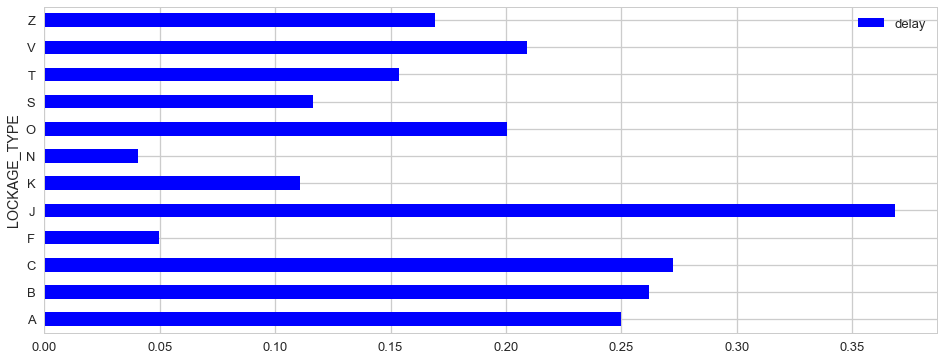

In [29]:
# Plot proportion delayed by Lockage Type
count_prop_lockage.plot(y='delay', use_index = True, kind='barh', figsize=[16,6], colormap='winter')

### Key to Lockage Types: 
1. A - Barges After Tow
2. B - Barges Before T ow
3. C - Consecutive (cuts > 1; same direction, same flotilla)
4. F - Fast Double (multi-chamber)
5. J - Jackknife
6. K - Knockout
7. N - Navigable Pass
8. O - Open Pass
9. S - Straight
10. T-BargeTransfer
11. V - Setover
12. Z - Other

In [30]:
# groupby LOCKA_NO to see counts by lock number: group_by_LOCK_NO
group_by_LOCK_NO = traf_sample_delay.groupby(['E_R_L', 'delay'])

In [31]:
# view categories by size and unstack by LOCK_NO
delays_lock_no = group_by_LOCK_NO.size().unstack()

In [32]:
# calculate percent of lockage events that are 'delays' (>110min)
prop_by_lock_no = pd.DataFrame(traf_sample_delay.groupby('E_R_L')['delay'].apply(lambda x: np.sum(x)/len(x)))

# Join count_delays_by_lock_no with prop_by_lock_no, view highest proportion of delays first
prop_lock_no = delays_lock_no.join(prop_by_lock_no)
prop_lock_no.sort_values(by=['delay'], ascending=False, inplace=True)
prop_lock_no.head()

,False,True,delay
E_R_L,,,
K7_FR_2,1.0,1.0,0.500000
B4_OB_4,37.0,13.0,0.260000
H3_TN_8,753.0,251.0,0.250000
B2_GI_3,3949.0,1316.0,0.249953
B2_GI_1,3185.0,1059.0,0.249529


In [33]:
# examine the top 10 delayed locks
prop_lock_no.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, K7_FR_2 to K5_AL_11
Data columns (total 3 columns):
False    186 non-null float64
True     180 non-null float64
delay    186 non-null float64
dtypes: float64(3)
memory usage: 5.8+ KB


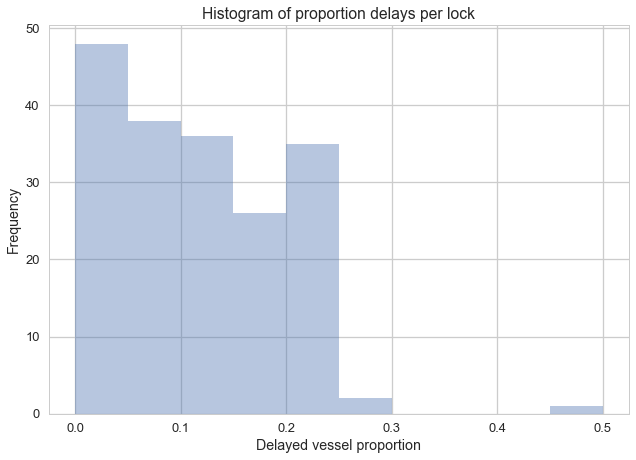

In [34]:
# Examine distribution of proportions of lock delays
sns.distplot(prop_lock_no.delay, bins=10, kde=False, rug=False);
plt.title('Histogram of proportion delays per lock');
plt.xlabel('Delayed vessel proportion');
plt.ylabel('Frequency');

#### Based on frequency of delay proportions I divided delay proportions into High and Low categories with 0.15 as the cutoff between High and Low.

## 4. Assign Delay Cateogories HIGH or LOW to Individual Locks Based on Proportion of Delays

In [35]:
# Assign each Lock as LOW or HIGH in prop_lock_no dataframe
prop_lock_no['cat_delay'] = np.where(prop_lock_no['delay'] > 0.15, 'HIGH', 'LOW')
prop_lock_no.rename(columns={'delay':'prop_delay'}, inplace=True)
prop_lock_no.head()

,False,True,prop_delay,cat_delay
E_R_L,,,,
K7_FR_2,1.0,1.0,0.500000,HIGH
B4_OB_4,37.0,13.0,0.260000,HIGH
H3_TN_8,753.0,251.0,0.250000,HIGH
B2_GI_3,3949.0,1316.0,0.249953,HIGH
B2_GI_1,3185.0,1059.0,0.249529,HIGH


In [36]:
prop_lock_no.info()

<class 'pandas.core.frame.DataFrame'>
Index: 186 entries, K7_FR_2 to K5_AL_11
Data columns (total 4 columns):
False         186 non-null float64
True          180 non-null float64
prop_delay    186 non-null float64
cat_delay     186 non-null object
dtypes: float64(3), object(1)
memory usage: 7.3+ KB


In [37]:
# Assign LOW & HIGH 'cat_delay' categories to each row based on lock ID 'E_R_L'
# Use pd.merge to add cat_delay category into a column
traf_sample_delay_cat = pd.merge(traf_sample_delay, prop_lock_no, how='left', right_index=True, left_on='E_R_L', right_on='E_R_L')
traf_sample_delay_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392000 entries, 0 to 391999
Data columns (total 32 columns):
EROC                    392000 non-null object
RIVER_CODE              392000 non-null object
LOCK_NO                 392000 non-null int64
CHMBR_NO                392000 non-null int64
OPS_ID                  392000 non-null object
LOCKAGE_TYPE            392000 non-null object
VESSEL_NO               392000 non-null int64
VESSEL_FUNCTION_TYPE    390657 non-null object
FLOTILLA_NO             269205 non-null object
ARRIVAL_DATE            392000 non-null datetime64[ns]
SOL_DATE                392000 non-null datetime64[ns]
BOW_OVER_SILL           281505 non-null datetime64[ns]
END_OF_ENTRY            281518 non-null datetime64[ns]
START_OF_EXIT           281561 non-null datetime64[ns]
END_OF_LOCKAGE          392000 non-null datetime64[ns]
NUM_CMRCL_PASSGRS       54260 non-null float64
ASST_CODE               27485 non-null object
SIGNAL_DATE             813 non-null datetime6

In [38]:
# New Main Traffic dataframe. Next steps (see below) are first to add stall stoppage info and then to remove 
#outliers, remove 'low' category, pick focal locks...
traf_sample_delay_cat.head()

,EROC,RIVER_CODE,LOCK_NO,CHMBR_NO,OPS_ID,LOCKAGE_TYPE,VESSEL_NO,VESSEL_FUNCTION_TYPE,FLOTILLA_NO,ARRIVAL_DATE,...,delay_time,delay,E_R_L,YYMMDD,hhmmss,pct75_delay_time,False,True,prop_delay,cat_delay
0,H2,OH,75,2,L5608584,S,2246973225,T,L3435504,2014-05-07 05:37:00,...,10.0,False,H2_OH_75,2014-05-07,05:37:00,146.0,3165.0,652.0,0.170815,HIGH
1,M5,MK,22,1,L7532719,C,967995540,T,L4611089,2017-04-06 00:40:00,...,0.0,False,M5_MK_22,2017-04-06,00:40:00,105.0,762.0,156.0,0.169935,HIGH
2,M3,GI,14,1,L6150873,O,3171419219,T,L3767838,2015-02-10 20:00:00,...,66.0,False,M3_GI_14,2015-02-10,20:00:00,197.0,6543.0,2171.0,0.249139,HIGH
3,H4,MN,25,1,L6581479,S,2064406338,T,L4017674,2015-09-20 02:20:00,...,20.0,False,H4_MN_25,2015-09-20,02:20:00,39.0,2179.0,85.0,0.037544,LOW
4,M3,GI,13,1,L7255211,O,1088709797,T,L4420842,2016-10-01 01:08:00,...,67.0,False,M3_GI_13,2016-10-01,01:08:00,216.0,6569.0,2177.0,0.248914,HIGH


## 5. Explore Patterns in Delay Count by Year, Month, Day for Vessels

In [39]:
# Remove all 'delay' = False rows: only_delay
only_delay = traf_sample_delay.query('delay != False')
only_delay.head()

,EROC,RIVER_CODE,LOCK_NO,CHMBR_NO,OPS_ID,LOCKAGE_TYPE,VESSEL_NO,VESSEL_FUNCTION_TYPE,FLOTILLA_NO,ARRIVAL_DATE,...,DEPARTURE_DATE,LINE_SEQ_NO,entry_time,exit_time,delay_time,delay,E_R_L,YYMMDD,hhmmss,pct75_delay_time
19,M3,GI,12,1,L6187320,O,1504534824,T,L3795181,2015-03-14 03:10:00,...,NaT,988292,NaN,NaN,70.0,True,M3_GI_12,2015-03-14,03:10:00,38.0
31,B6,MI,9,1,L5669493,C,4092571819,T,L3472944,2014-06-05 12:10:00,...,NaT,51407,9.0,25.0,89.0,True,B6_MI_9,2014-06-05,12:10:00,83.5
39,B2,GI,4,1,L6475971,S,3020701214,T,L3963416,2015-08-03 09:33:00,...,NaT,12767,10.0,10.0,649.0,True,B2_GI_4,2015-08-03,09:33:00,470.0
43,B2,GI,8,1,L7514042,S,1815299047,T,L4598081,2017-03-25 14:08:00,...,NaT,836439,2.0,4.0,263.0,True,B2_GI_8,2017-03-25,14:08:00,190.0
72,B5,IL,8,1,L6125614,C,291263268,T,L3748619,2015-01-23 09:00:00,...,NaT,733302,6.0,24.0,470.0,True,B5_IL_8,2015-01-23,09:00:00,346.0


In [40]:
# Explore delays per year
group_year = only_delay.groupby(pd.Grouper(key='ARRIVAL_DATE', freq="Y")) 
count_delays_by_year = group_year.size()
count_delays_by_year

ARRIVAL_DATE
2013-12-31     9150
2014-12-31    11553
2015-12-31    12493
2016-12-31    12749
2017-12-31    12791
Freq: A-DEC, dtype: int64

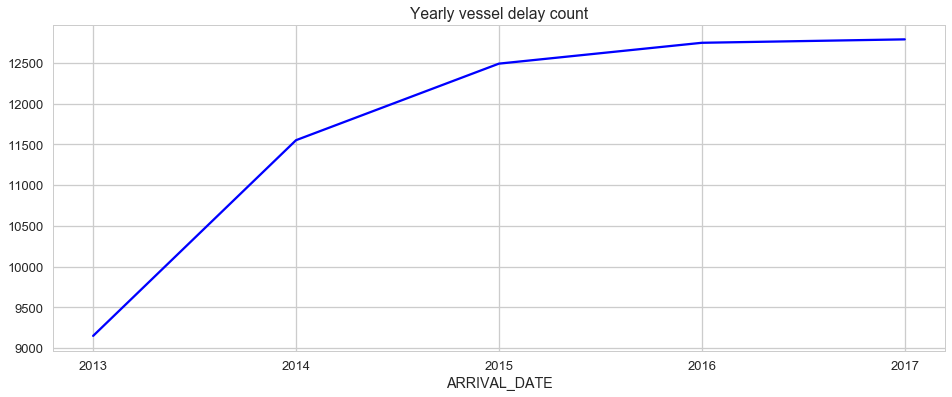

In [41]:
# Plot count of delayed vessels by year
count_delays_by_year.plot(kind='line', figsize=[16,6], colormap='winter',
                         title='Yearly vessel delay count')

In [42]:
# Explore delays per month
group_month = only_delay.groupby(pd.Grouper(key='ARRIVAL_DATE', freq="M")) 
count_delays_by_month = group_month.size()

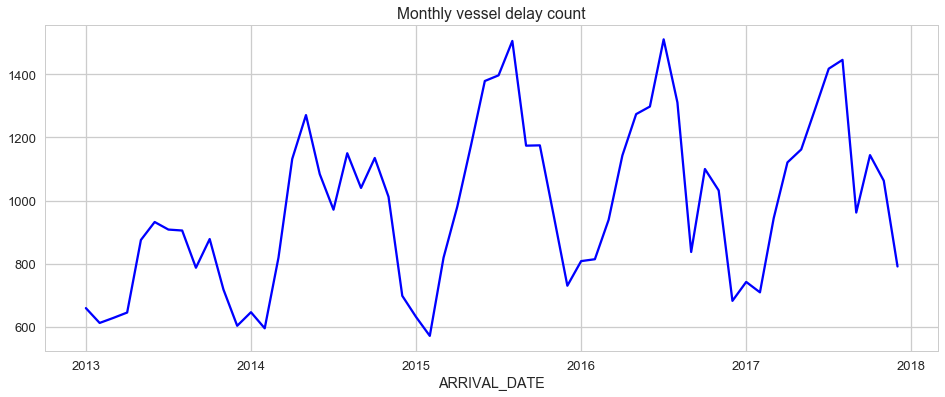

In [43]:
# Plot count of delayed vessels by month
count_delays_by_month.plot(kind='line', figsize=[16,6], colormap='winter',
                         title='Monthly vessel delay count')

In [44]:
# Explore delays per day
group_day = only_delay.groupby(pd.Grouper(key='ARRIVAL_DATE', freq="D")) 
count_delays_by_day = group_day.size()

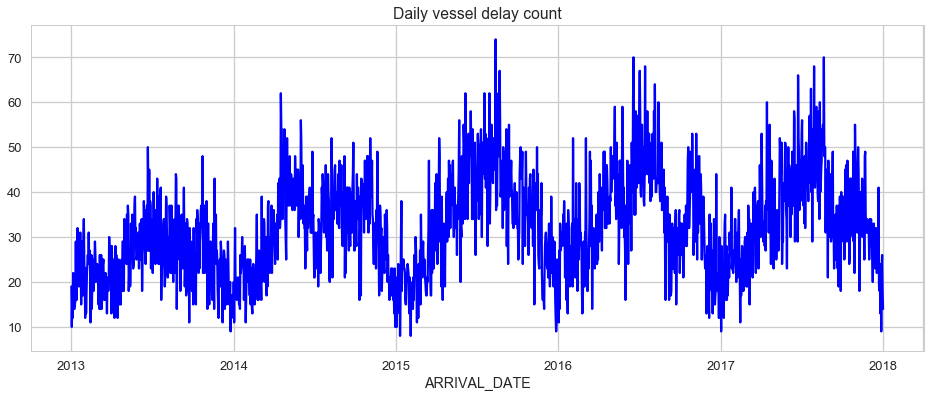

In [45]:
# Plot count of delayed vessels by day
count_delays_by_day.plot(kind='line', figsize=[16,6], colormap='winter',
                         title='Daily vessel delay count')

## 6.  Examine Delays Per Lock & Per Day

In [46]:
# Group by lock and day with count of delay (true/false)
lock_year = pd.DataFrame(traf_sample_delay.groupby(['E_R_L','YYMMDD', 'delay'])['delay'].count())
lock_year.head()

delay
E_R_L    YYMMDD     delay       
B2_AT_11 2013-01-01 False      2
         2013-01-04 False      2
         2013-01-06 False      1
         2013-01-07 False      1
         2013-01-08 False      1

In [47]:
# turn 'delay' index into a column
lock_year.rename(columns={'delay':'count'}, inplace=True)
lock_year.reset_index(inplace=True) 
lock_year.head()

,E_R_L,YYMMDD,delay,count
0,B2_AT_11,2013-01-01,False,2
1,B2_AT_11,2013-01-04,False,2
2,B2_AT_11,2013-01-06,False,1
3,B2_AT_11,2013-01-07,False,1
4,B2_AT_11,2013-01-08,False,1


In [49]:
# Tranform 'YYMMDD' to datetime field
lock_year['YYMMDD'] = pd.to_datetime(lock_year['YYMMDD'])

# Use pd.Grouper to get counts of True and False rows per Lock/Year
delay_day_lock = lock_year.groupby(by=[pd.Grouper(key='E_R_L'), pd.Grouper(key='YYMMDD', freq='Y'),
                                                pd.Grouper(key='delay')]).count()
delay_day_lock2 = delay_day_lock.unstack()
delay_day_lock2.head()

count       
delay                False  True 
E_R_L    YYMMDD                  
B2_AT_11 2013-12-31  124.0  123.0
         2014-12-31  180.0   51.0
         2015-12-31  169.0   66.0
         2016-12-31  190.0   15.0
         2017-12-31  171.0    6.0

In [56]:
# reset each level of index, drop hierarchical columns, rename columns if needed
delay_day_lock2.reset_index(level='YYMMDD',inplace=True) # iterate through each level
delay_day_lock2.reset_index(level='E_R_L',inplace=True) # iterate through each level

# Drop the top row of column names and re-name each column
delay_day_lock2.columns = delay_day_lock2.columns.droplevel(0)
delay_day_lock2.columns = ['E_R_L', 'YYMMDD', 'False', 'True']

# Calculate annual percentage of days with delay
delay_day_lock2['yearly_delay_days'] = (delay_day_lock2['True'] / 365)
delay_day_lock2.head()

,E_R_L,YYMMDD,False,True,yearly_delay_days
0,B2_AT_11,2013-12-31,124.0,123.0,0.336986
1,B2_AT_11,2014-12-31,180.0,51.0,0.139726
2,B2_AT_11,2015-12-31,169.0,66.0,0.180822
3,B2_AT_11,2016-12-31,190.0,15.0,0.041096
4,B2_AT_11,2017-12-31,171.0,6.0,0.016438


In [57]:
# Calculate statistics of yearly delays per lock
year_daily = delay_day_lock2.pivot_table(columns='E_R_L', values='yearly_delay_days', aggfunc=[np.mean])

# convert to dataframe and transpose
year_daily_stats = pd.DataFrame(year_daily).T
year_daily_stats.reset_index(inplace=True)
year_daily_stats.drop(labels='level_0', axis='columns', inplace=True)
year_daily_stats.set_index('E_R_L', inplace=True)
year_daily_stats.head(15)

,yearly_delay_days
E_R_L,
B2_AT_11,0.143014
B2_CA_23,0.023014
B2_FB_41,0.513425
B2_GI_1,0.333151
B2_GI_2,0.437808
B2_GI_21,0.023562
B2_GI_22,0.046575
B2_GI_3,0.322740
B2_GI_4,0.326027


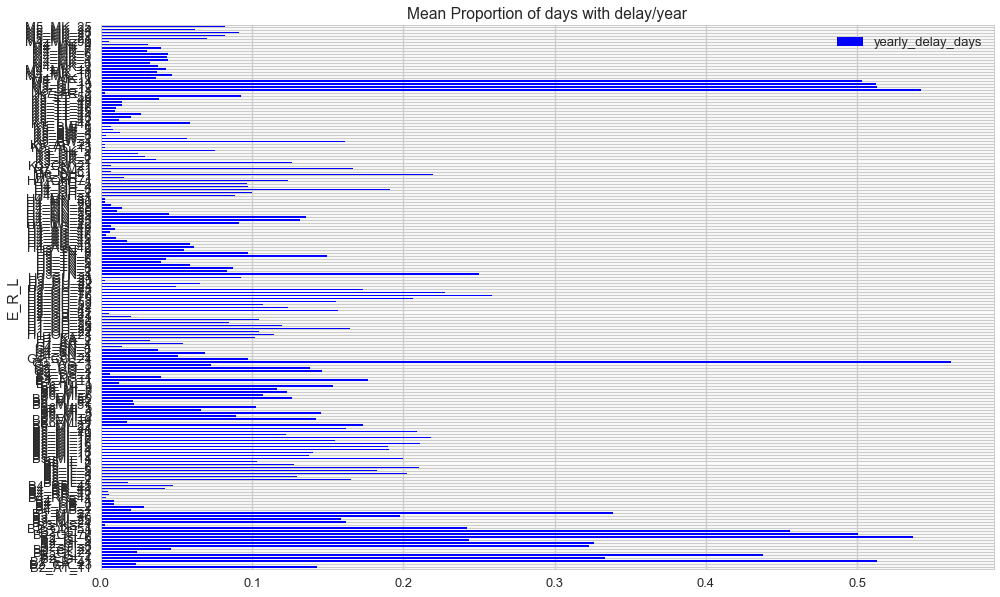

In [58]:
# Plot mean annual delay proportion
year_daily_stats.plot(kind='barh', figsize=[16,10], colormap='winter', title='Mean Proportion of days with delay/year')

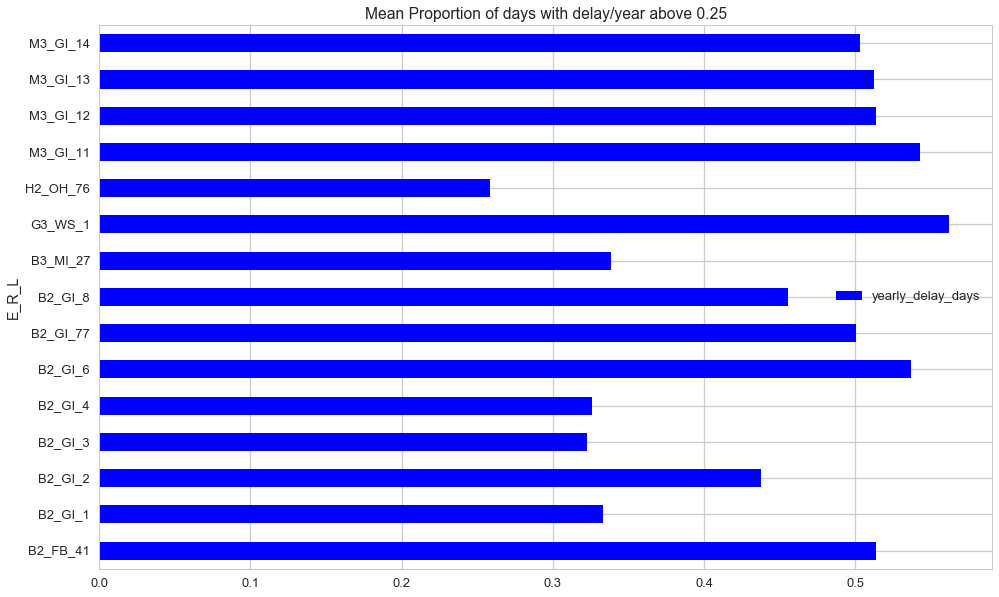

In [59]:
# Keep only locks with delay proportions over 0.25
year_daily_high = year_daily_stats[year_daily_stats['yearly_delay_days'] > 0.25]
year_daily_high.plot(kind='barh', figsize=[16,10], colormap='winter',
                     title='Mean Proportion of days with delay/year above 0.25')

In [60]:
# These are the locks with the highest proportion of delay-days per year
year_daily_high.head(20)
# I selected 10 of these for the reduced ML dataset: 
# B2_FB_41, B2_GI_3, B2_GI_4, B2_GI_77, B3_MI_27, G3_WS_1, H2_OH_76, M3_GI_11, M3_GI_12, M3_GI_14

,yearly_delay_days
E_R_L,
B2_FB_41,0.513425
B2_GI_1,0.333151
B2_GI_2,0.437808
B2_GI_3,0.322740
B2_GI_4,0.326027
B2_GI_6,0.536986
B2_GI_77,0.500274
B2_GI_8,0.455342
B3_MI_27,0.338630


In [61]:
# Most locks have a low proportion of days with delays
year_daily_stats.describe()

,yearly_delay_days
count,180.000000
mean,0.110956
std,0.122796
min,0.002740
25%,0.022740
50%,0.078904
75%,0.153699
max,0.562192


In [62]:
# Majority of Locks per Day have 2 or fewer vessels. Max count of True or false at one Lock on one day is 27.
lock_year.describe()

,count
count,197971.000000
mean,1.980088
std,1.522788
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,27.000000


### The 'lock_year' dataframe can be used to create subplots by lock of True/False delay counts over time.

In [63]:
# pickle modified traf_sample_delay for later use. This dataframe has delay defined per lock.
traf_sample_delay_cat.to_pickle('traf_sample_delay.pickle')

## 7. Add Stall Stoppage information to Main Traffic Delay Dataframe

In [64]:
# get info on stall_stop_13_17
stall_stop_13_17.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83492 entries, 2013-02-20 12:00:00 to 2013-06-27 19:01:00
Data columns (total 13 columns):
EROC             83492 non-null object
RIVER_CODE       83492 non-null object
LOCK_NO          83492 non-null int64
CHMBR_NO         83492 non-null int64
BEG_STOP_DATE    83492 non-null datetime64[ns]
END_STOP_DATE    83492 non-null datetime64[ns]
SCHEDULED        83492 non-null object
REASON_CODE      83492 non-null object
COMMENTS         24351 non-null object
stop_minutes     83492 non-null float64
stop_days        83492 non-null float64
YYMMDD           83492 non-null datetime64[ns]
E_R_L            83492 non-null object
dtypes: datetime64[ns](3), float64(2), int64(2), object(6)
memory usage: 8.9+ MB


In [65]:
# create smaller stall stop df so columns do not repeat when merged, reorder columns
# Get list of columns to remove duplicates with traf_sample and to put 'E_R_L' & 'YYMMDD' first
names = list(stall_stop_13_17.columns.values)
print(names)

['EROC', 'RIVER_CODE', 'LOCK_NO', 'CHMBR_NO', 'BEG_STOP_DATE', 'END_STOP_DATE', 'SCHEDULED', 'REASON_CODE', 'COMMENTS', 'stop_minutes', 'stop_days', 'YYMMDD', 'E_R_L']


In [66]:
# Keep and reorder columns you need
stalls = stall_stop_13_17[['E_R_L', 'YYMMDD', 'END_STOP_DATE', 'SCHEDULED', 'REASON_CODE', 'COMMENTS', 
                           'stop_minutes', 'stop_days']]
# reset index of stalls so that BEG_STOP_DATE is a column not an index
stalls = stalls.reset_index()
stalls.head()

,BEG_STOP_DATE,E_R_L,YYMMDD,END_STOP_DATE,SCHEDULED,REASON_CODE,COMMENTS,stop_minutes,stop_days
0,2013-02-20 12:00:00,M5_MK_25,2013-02-20,2013-02-20 16:00:00,Y,T,LOS Maint.,240.0,0.166667
1,2013-02-21 12:00:00,M5_MK_25,2013-02-21,2013-02-21 16:00:00,Y,T,LOS Maint.,240.0,0.166667
2,2013-02-23 12:00:00,M5_MK_25,2013-02-23,2013-02-23 16:00:00,Y,T,Greased D/S L/W mitor gate,240.0,0.166667
3,2013-02-24 12:00:00,M5_MK_25,2013-02-24,2013-02-24 16:00:00,Y,T,Checked lock emergency lights and all gallery ...,240.0,0.166667
4,2013-02-25 11:00:00,M5_MK_25,2013-02-25,2013-02-25 15:00:00,Y,T,LOS,240.0,0.166667


In [67]:
# re-organize again
stalls = stalls[['E_R_L', 'YYMMDD', 'BEG_STOP_DATE', 'END_STOP_DATE', 'SCHEDULED', 'REASON_CODE', 'COMMENTS', 
                           'stop_minutes', 'stop_days']]
# reset index of stalls so that BEG_STOP_DATE is a column not an index
stalls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83492 entries, 0 to 83491
Data columns (total 9 columns):
E_R_L            83492 non-null object
YYMMDD           83492 non-null datetime64[ns]
BEG_STOP_DATE    83492 non-null datetime64[ns]
END_STOP_DATE    83492 non-null datetime64[ns]
SCHEDULED        83492 non-null object
REASON_CODE      83492 non-null object
COMMENTS         24351 non-null object
stop_minutes     83492 non-null float64
stop_days        83492 non-null float64
dtypes: datetime64[ns](3), float64(2), object(4)
memory usage: 5.7+ MB


In [80]:
# Explore Stall Stop Info in 'stalls'
#stalls.E_R_L.value_counts() # 171 Locks have stall info
#stalls.YYMMDD.value_counts() # 1826 days over 5 years have stall info, 17 to 89 locks per day have stalls
stalls.SCHEDULED.value_counts()
# stalls df has 44842 scheduled stall stoppage rows and 38650 that were not scheduled
# in stalls df there are 46471 duplicated rows for lock-date combinations. These are for multiple stalls/day

Y    44842
N    38650
Name: SCHEDULED, dtype: int64

In [83]:
# divide stalls into two dataframes: one with SCHEDULED = Y
y_sched_stall = stalls.loc[stalls['SCHEDULED'] == 'Y']
y_sched_stall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44842 entries, 0 to 83491
Data columns (total 9 columns):
E_R_L            44842 non-null object
YYMMDD           44842 non-null datetime64[ns]
BEG_STOP_DATE    44842 non-null datetime64[ns]
END_STOP_DATE    44842 non-null datetime64[ns]
SCHEDULED        44842 non-null object
REASON_CODE      44842 non-null object
COMMENTS         11310 non-null object
stop_minutes     44842 non-null float64
stop_days        44842 non-null float64
dtypes: datetime64[ns](3), float64(2), object(4)
memory usage: 3.4+ MB


In [84]:
# divide stalls into two dataframes: one with schdeuled = N
n_sched_stall = stalls.loc[stalls['SCHEDULED'] == 'N']
n_sched_stall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38650 entries, 18 to 83096
Data columns (total 9 columns):
E_R_L            38650 non-null object
YYMMDD           38650 non-null datetime64[ns]
BEG_STOP_DATE    38650 non-null datetime64[ns]
END_STOP_DATE    38650 non-null datetime64[ns]
SCHEDULED        38650 non-null object
REASON_CODE      38650 non-null object
COMMENTS         13041 non-null object
stop_minutes     38650 non-null float64
stop_days        38650 non-null float64
dtypes: datetime64[ns](3), float64(2), object(4)
memory usage: 2.9+ MB


In [86]:
y_sched_stall.REASON_CODE.value_counts()

BB    25744
T      9511
S      2169
EE     1824
X      1282
Y       854
N       631
U       630
Z       569
DD      396
FF      287
A       255
R        95
G        90
M        83
F        69
Q        60
K        52
GG       50
H        42
I        34
E        18
L        17
AA       17
J        14
O        12
B        12
W         7
P         5
CC        4
V         4
D         3
C         2
Name: REASON_CODE, dtype: int64

In [85]:
n_sched_stall.REASON_CODE.value_counts()

S     7042
GG    5134
T     5016
N     4416
Y     2303
A     1996
Z     1627
EE    1528
K     1244
BB    1033
R      990
F      869
G      685
H      660
X      561
Q      539
U      538
E      346
M      339
L      297
DD     215
I      207
O      196
J      176
AA     159
B      125
FF     121
P       91
CC      57
D       54
V       51
W       24
C       11
Name: REASON_CODE, dtype: int64

### Stall Stoppage Reason Codes

1. A - Fog
2. AA - Accident or collision in lock
3. B - Rain
4. BB - Closed (unmanned shift)
5. C - Sleet or Hail
6. CC - Grounding
7. D - Snow
8. DD - Environmental (i.e. fish, animals, oil spills, etc.)
9. E - Wind
10. EE - Repairing lock or lock hardware
11. F - Lightning
12. FF - Lock OK; Unused for other reasons (i.e. River closing etc.)
13. G - Low Water
14. GG - Bye Time
15. H - Iceonoraroundtow
16. I - River current or Outdraft condition
17. J - Flood
18. K - Interference by other vessel(s)
19. L - Tow malfunction or breakdown
20. M - Tow staff occupied with other duties
21. N - Operations (run-spill-divert water, flush seals-reserve etc)
22. O - Debris
23. P - Tow accident or collision
24. Q - Debris in lock recess or lock chamber
25. R- Lock hardware or equipment malfunction
26. S - Lock staff occupied with other duties
27. T - Maintaining lock or lock equipment
28. U - Ice on lock or lock equipment
29. V - Tow detained by Coast Guardor Corps
30. W - Collision or Accident
31. X - Bridge or other structure (i.e., railway, pontoon, swing, etc.)
32. Y - Inspection or testing lock
33. Z - Other

In [105]:
# Make a dataframe of unique Lock/Days where there was a scheduled delay - these will be dropped from Traffic
planned_stalls = y_sched_stall.drop_duplicates(subset=['E_R_L','YYMMDD'])
# check that Lock/Day combos are all unique
planned_stalls.groupby(['E_R_L','YYMMDD']).count().max()
# make a two-column dataframe of Lock/Day pairs to drop from Traffic
plan_stall_drop = planned_stalls[['E_R_L','YYMMDD']]
plan_stall_drop['planned'] = True # there is a tidier way to do this (gives a copy warning)
plan_stall_drop.head()

,E_R_L,YYMMDD,planned
0,M5_MK_25,2013-02-20,True
1,M5_MK_25,2013-02-21,True
2,M5_MK_25,2013-02-23,True
3,M5_MK_25,2013-02-24,True
4,M5_MK_25,2013-02-25,True


In [107]:
plan_stall_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36338 entries, 0 to 83491
Data columns (total 3 columns):
E_R_L      36338 non-null object
YYMMDD     36338 non-null datetime64[ns]
planned    36338 non-null bool
dtypes: bool(1), datetime64[ns](1), object(1)
memory usage: 887.2+ KB


In [100]:
# Now pivot so that there is one row per lock-day and multiple columns for other columns
unplanned_stall = n_sched_stall.pivot_table(index=['E_R_L','YYMMDD'], columns='REASON_CODE', values='stop_minutes',
                                      aggfunc=np.mean, fill_value = 0, dropna=True)
unplanned_stall.head()

REASON_CODE            A  AA    B    BB  C   CC    D   DD    E     EE ...   \
E_R_L    YYMMDD                                                       ...    
B2_BT_31 2016-07-12  0.0   0  0.0  1020  0  0.0  0.0  0.0  0.0    0.0 ...    
B2_CA_23 2014-02-19  0.0   0  0.0     0  0  0.0  0.0  0.0  0.0    0.0 ...    
         2015-03-03  0.0   0  0.0     0  0  0.0  0.0  0.0  0.0  120.0 ...    
         2015-05-29  0.0   0  0.0     0  0  0.0  0.0  0.0  0.0    0.0 ...    
B2_FB_41 2013-02-14  0.0  88  0.0     0  0  0.0  0.0  0.0  0.0    0.0 ...    

REASON_CODE            Q    R    S     T    U    V  W    X    Y    Z  
E_R_L    YYMMDD                                                       
B2_BT_31 2016-07-12  0.0  0.0  0.0   0.0  0.0  0.0  0  0.0  0.0  0.0  
B2_CA_23 2014-02-19  0.0  0.0  0.0  60.0  0.0  0.0  0  0.0  0.0  0.0  
         2015-03-03  0.0  0.0  0.0   0.0  0.0  0.0  0  0.0  0.0  0.0  
         2015-05-29  0.0  0.0  0.0  25.0  0.0  0.0  0  0.0  0.0  0.0  
B2_FB_41 2013-02-14  0.0  0.0  0.0   0.0  0.0  0.0  0  0.0  0.0  0.0  

[5 rows x 33 columns]

In [102]:
# remove multi-index before merge
#unplanned_stall.reset_index(level='YYMMDD',inplace=True)
unplanned_stall.reset_index(level='E_R_L',inplace=True)
unplanned_stall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20674 entries, 0 to 20673
Data columns (total 35 columns):
E_R_L     20674 non-null object
YYMMDD    20674 non-null datetime64[ns]
A         20674 non-null float64
AA        20674 non-null int64
B         20674 non-null float64
BB        20674 non-null int64
C         20674 non-null int64
CC        20674 non-null float64
D         20674 non-null float64
DD        20674 non-null float64
E         20674 non-null float64
EE        20674 non-null float64
F         20674 non-null float64
FF        20674 non-null float64
G         20674 non-null float64
GG        20674 non-null float64
H         20674 non-null float64
I         20674 non-null float64
J         20674 non-null float64
K         20674 non-null float64
L         20674 non-null float64
M         20674 non-null float64
N         20674 non-null float64
O         20674 non-null float64
P         20674 non-null float64
Q         20674 non-null float64
R         20674 non-null float64


In [103]:
# Format YYMMDD as datetime for merging
traf_sample_delay_cat['YYMMDD'] = pd.to_datetime(traf_sample_delay_cat['YYMMDD'])

# First, create column 'planned' with True/False lock/day planned stall
# Second, merge traffic with unplanned stalls

In [108]:
# Merge traf_sample_delay_cat with plan_stall_drop to get 'True' for Lock/Days where there was a planned stall stop
traf_sample_plan = pd.merge(traf_sample_delay_cat, plan_stall_drop, how='left', left_on=['E_R_L', 'YYMMDD'], 
                            right_on = ['E_R_L', 'YYMMDD'])
traf_sample_plan['planned'] = traf_sample_plan['planned'].fillna(value=False)
traf_sample_plan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392000 entries, 0 to 391999
Data columns (total 33 columns):
EROC                    392000 non-null object
RIVER_CODE              392000 non-null object
LOCK_NO                 392000 non-null int64
CHMBR_NO                392000 non-null int64
OPS_ID                  392000 non-null object
LOCKAGE_TYPE            392000 non-null object
VESSEL_NO               392000 non-null int64
VESSEL_FUNCTION_TYPE    390657 non-null object
FLOTILLA_NO             269205 non-null object
ARRIVAL_DATE            392000 non-null datetime64[ns]
SOL_DATE                392000 non-null datetime64[ns]
BOW_OVER_SILL           281505 non-null datetime64[ns]
END_OF_ENTRY            281518 non-null datetime64[ns]
START_OF_EXIT           281561 non-null datetime64[ns]
END_OF_LOCKAGE          392000 non-null datetime64[ns]
NUM_CMRCL_PASSGRS       54260 non-null float64
ASST_CODE               27485 non-null object
SIGNAL_DATE             813 non-null datetime6

In [110]:
# Merge traf_sample_plan with stall_stop_13_17 to weed out planned delays
traf_sample_plan_yn = pd.merge(traf_sample_plan, unplanned_stall, how='left', left_on=['E_R_L', 'YYMMDD'], 
                               right_on = ['E_R_L', 'YYMMDD'])
traf_sample_plan_yn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392000 entries, 0 to 391999
Data columns (total 66 columns):
EROC                    392000 non-null object
RIVER_CODE              392000 non-null object
LOCK_NO                 392000 non-null int64
CHMBR_NO                392000 non-null int64
OPS_ID                  392000 non-null object
LOCKAGE_TYPE            392000 non-null object
VESSEL_NO               392000 non-null int64
VESSEL_FUNCTION_TYPE    390657 non-null object
FLOTILLA_NO             269205 non-null object
ARRIVAL_DATE            392000 non-null datetime64[ns]
SOL_DATE                392000 non-null datetime64[ns]
BOW_OVER_SILL           281505 non-null datetime64[ns]
END_OF_ENTRY            281518 non-null datetime64[ns]
START_OF_EXIT           281561 non-null datetime64[ns]
END_OF_LOCKAGE          392000 non-null datetime64[ns]
NUM_CMRCL_PASSGRS       54260 non-null float64
ASST_CODE               27485 non-null object
SIGNAL_DATE             813 non-null datetime6

In [111]:
traf_sample_plan_yn.head()

,EROC,RIVER_CODE,LOCK_NO,CHMBR_NO,OPS_ID,LOCKAGE_TYPE,VESSEL_NO,VESSEL_FUNCTION_TYPE,FLOTILLA_NO,ARRIVAL_DATE,...,Q,R,S,T,U,V,W,X,Y,Z
0,H2,OH,75,2,L5608584,S,2246973225,T,L3435504,2014-05-07 05:37:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M5,MK,22,1,L7532719,C,967995540,T,L4611089,2017-04-06 00:40:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M3,GI,14,1,L6150873,O,3171419219,T,L3767838,2015-02-10 20:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H4,MN,25,1,L6581479,S,2064406338,T,L4017674,2015-09-20 02:20:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M3,GI,13,1,L7255211,O,1088709797,T,L4420842,2016-10-01 01:08:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 8. Start to Build Focal DataFrame for Machine Learning

In [131]:
# First, reduce the full dataframe of traffic data by deleting low traffic locks/rivers
# Remove all delay_cat = 'LOW' rows
ML = traf_sample_plan_yn[traf_sample_plan_yn.cat_delay != 'LOW']

# Remove outlier lock, K7_FR_2. It has low traffic but very high ratio of delays
ML_traf = ML[ML.E_R_L != 'K7_FR_2']

# Remove individual rivers with fewer than 10 delays over 5 years
to_drop = ['FR', 'AP', 'AL', 'IN', 'KS', 'BT', 'CT', 'WI', 'HU', 'CN']
ML_traf_sample = ML_traf.query('RIVER_CODE not in @to_drop')

# Remove individual locks with fewer than 1000 delays over 5 years
drop_lock = ['G2_CO_2', 'G4_CO_24', 'M5_MK_23', 'M5_MK_22', 'H3_TN_8', 'H1_KA_3', 'M5_MK_21', 
             'M5_MK_25', 'H3_TN_9', 'B4_RR_45', 'G4_SN_2', 'B2_GI_22', 'E4_DS_1', 'B4_OB_1', 
             'B4_OB_2', 'B4_OB_3', 'B4_OB_4']
ML_traf_sample_d = ML_traf_sample.query('E_R_L not in @drop_lock')

# RUN THIS NEXT ROW TO DROP ALL PLANNED STOPS. USE THE SAME CODE UNTIL THE DEDUPLICATED FINAL STEP
ML_traf_sample_drop = ML_traf_sample_d.query('planned != True')

# before dropping planned stops there are 182169 rows in ML_traf_sample_drop
# afterward there are 171391 rows
ML_traf_sample_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171391 entries, 0 to 391999
Data columns (total 66 columns):
EROC                    171391 non-null object
RIVER_CODE              171391 non-null object
LOCK_NO                 171391 non-null int64
CHMBR_NO                171391 non-null int64
OPS_ID                  171391 non-null object
LOCKAGE_TYPE            171391 non-null object
VESSEL_NO               171391 non-null int64
VESSEL_FUNCTION_TYPE    171374 non-null object
FLOTILLA_NO             140456 non-null object
ARRIVAL_DATE            171391 non-null datetime64[ns]
SOL_DATE                171391 non-null datetime64[ns]
BOW_OVER_SILL           117638 non-null datetime64[ns]
END_OF_ENTRY            117632 non-null datetime64[ns]
START_OF_EXIT           117650 non-null datetime64[ns]
END_OF_LOCKAGE          171391 non-null datetime64[ns]
NUM_CMRCL_PASSGRS       8489 non-null float64
ASST_CODE               14907 non-null object
SIGNAL_DATE             773 non-null datetime64

In [132]:
# check: no more planned = True in df
ML_traf_sample_drop.planned.value_counts()

False    171391
Name: planned, dtype: int64

In [133]:
# Confirm that there are duplicate lock/days
# Group by lock and day with count of delay (true/false)
lock_day = pd.DataFrame(ML_traf_sample_drop.groupby(['E_R_L', 'YYMMDD', 'delay'])['delay'].count())
lock_day.columns = ['count']
lock_day.reset_index(level='delay', inplace=True)
lock_day.reset_index(level='YYMMDD', inplace=True) # had to do this one index at a time with level='delay', etc
lock_day.reset_index(level='E_R_L', inplace=True)
lock_day.head()

,E_R_L,YYMMDD,delay,count
0,B2_AT_11,2013-01-01,False,2
1,B2_AT_11,2013-01-04,False,2
2,B2_AT_11,2013-01-06,False,1
3,B2_AT_11,2013-01-07,False,1
4,B2_AT_11,2013-01-08,False,1


In [134]:
# First, divide remaining traffic data into two dataframes: delay=True & delay=False
# Within each df randomize the order of rows, drop duplicates of ['E_R_L','YYMMDD','delay']
# Concatenate the delay=True & delay=False dfs
# Sort on ['E_R_L','YYMMDD','delay'] and remove duplicates with keep=last

# divide traffic into two dataframes: one with delay = True
# Remove all 'delay' = False rows: ML_traf_delay_true
ML_traf_delay_true = ML_traf_sample_drop.query('delay != False')
ML_traf_delay_true.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36955 entries, 19 to 391980
Data columns (total 66 columns):
EROC                    36955 non-null object
RIVER_CODE              36955 non-null object
LOCK_NO                 36955 non-null int64
CHMBR_NO                36955 non-null int64
OPS_ID                  36955 non-null object
LOCKAGE_TYPE            36955 non-null object
VESSEL_NO               36955 non-null int64
VESSEL_FUNCTION_TYPE    36953 non-null object
FLOTILLA_NO             33255 non-null object
ARRIVAL_DATE            36955 non-null datetime64[ns]
SOL_DATE                36955 non-null datetime64[ns]
BOW_OVER_SILL           27018 non-null datetime64[ns]
END_OF_ENTRY            27022 non-null datetime64[ns]
START_OF_EXIT           27025 non-null datetime64[ns]
END_OF_LOCKAGE          36955 non-null datetime64[ns]
NUM_CMRCL_PASSGRS       1588 non-null float64
ASST_CODE               2882 non-null object
SIGNAL_DATE             47 non-null datetime64[ns]
DEPARTURE_DA

In [135]:
# divide traffic into two dataframes: one with delay = False
# Remove all 'delay' = True rows: traf_stop_delay
ML_traf_delay_false = ML_traf_sample_drop.query('delay != True')
ML_traf_delay_false.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134436 entries, 0 to 391999
Data columns (total 66 columns):
EROC                    134436 non-null object
RIVER_CODE              134436 non-null object
LOCK_NO                 134436 non-null int64
CHMBR_NO                134436 non-null int64
OPS_ID                  134436 non-null object
LOCKAGE_TYPE            134436 non-null object
VESSEL_NO               134436 non-null int64
VESSEL_FUNCTION_TYPE    134421 non-null object
FLOTILLA_NO             107201 non-null object
ARRIVAL_DATE            134436 non-null datetime64[ns]
SOL_DATE                134436 non-null datetime64[ns]
BOW_OVER_SILL           90620 non-null datetime64[ns]
END_OF_ENTRY            90610 non-null datetime64[ns]
START_OF_EXIT           90625 non-null datetime64[ns]
END_OF_LOCKAGE          134436 non-null datetime64[ns]
NUM_CMRCL_PASSGRS       6901 non-null float64
ASST_CODE               12025 non-null object
SIGNAL_DATE             726 non-null datetime64[ns

In [136]:
# randomize row order and drop duplicates for the subset of columns ['E_R_L','YYMMDD'] in ML_traf_delay_true
ML_traf_1_true = ML_traf_delay_true.sample(frac=1, random_state=42).drop_duplicates(subset=['E_R_L','YYMMDD'])
ML_traf_1_true.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20837 entries, 265360 to 169347
Data columns (total 66 columns):
EROC                    20837 non-null object
RIVER_CODE              20837 non-null object
LOCK_NO                 20837 non-null int64
CHMBR_NO                20837 non-null int64
OPS_ID                  20837 non-null object
LOCKAGE_TYPE            20837 non-null object
VESSEL_NO               20837 non-null int64
VESSEL_FUNCTION_TYPE    20836 non-null object
FLOTILLA_NO             18530 non-null object
ARRIVAL_DATE            20837 non-null datetime64[ns]
SOL_DATE                20837 non-null datetime64[ns]
BOW_OVER_SILL           15903 non-null datetime64[ns]
END_OF_ENTRY            15903 non-null datetime64[ns]
START_OF_EXIT           15905 non-null datetime64[ns]
END_OF_LOCKAGE          20837 non-null datetime64[ns]
NUM_CMRCL_PASSGRS       900 non-null float64
ASST_CODE               1709 non-null object
SIGNAL_DATE             23 non-null datetime64[ns]
DEPARTURE

In [137]:
# randomize row order and drop duplicates for the subset of columns ['E_R_L','YYMMDD'] in ML_traf_delay_false
ML_traf_1_false = ML_traf_delay_false.sample(frac=1, random_state=42).drop_duplicates(subset=['E_R_L','YYMMDD'])
ML_traf_1_false.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55050 entries, 220036 to 368247
Data columns (total 66 columns):
EROC                    55050 non-null object
RIVER_CODE              55050 non-null object
LOCK_NO                 55050 non-null int64
CHMBR_NO                55050 non-null int64
OPS_ID                  55050 non-null object
LOCKAGE_TYPE            55050 non-null object
VESSEL_NO               55050 non-null int64
VESSEL_FUNCTION_TYPE    55041 non-null object
FLOTILLA_NO             43280 non-null object
ARRIVAL_DATE            55050 non-null datetime64[ns]
SOL_DATE                55050 non-null datetime64[ns]
BOW_OVER_SILL           42484 non-null datetime64[ns]
END_OF_ENTRY            42479 non-null datetime64[ns]
START_OF_EXIT           42484 non-null datetime64[ns]
END_OF_LOCKAGE          55050 non-null datetime64[ns]
NUM_CMRCL_PASSGRS       2655 non-null float64
ASST_CODE               6343 non-null object
SIGNAL_DATE             228 non-null datetime64[ns]
DEPARTU

In [138]:
# Concatenate ML_traf_1_true & ML_traf_1_false, sort by Lock/Day/Delay
ML_traf_1_TF = pd.concat([ML_traf_1_true, ML_traf_1_false])
ML_traf_1_TF.sort_values(by=['E_R_L','YYMMDD','delay'], inplace=True)
ML_traf_1_TF.delay.value_counts()

False    55050
True     20837
Name: delay, dtype: int64

In [140]:
# randomize the order of rows and drop duplicate rows for the subset of columns ['E_R_L','YYMMDD','delay']
# since ML_traf_1_TF is sorted keep='last' option should keep all delay='True' rows (check False counts)
ML_traf_no_planned_stall = ML_traf_1_TF.drop_duplicates(subset=['E_R_L','YYMMDD'], keep='last')
ML_traf_no_planned_stall.delay.value_counts()

False    39246
True     20837
Name: delay, dtype: int64

In [128]:
# pickle ML_traf_sample_final for later use. This dataframe has one row per lock/day
# This version has all stall stoppages
#ML_traf_sample_final.to_pickle('ML_traf_sample_final.pickle')

In [141]:
# pickle ML_traf_no_planned_stops for later use. This dataframe has one row per lock/day and no planned stall stops
ML_traf_no_planned_stall.to_pickle('ML_traf_no_planned_stall.pickle')

## 9. Delete unneccesary columns, create full and reduced datasets for ML (no planned stalls)

In [145]:
# Drop unneccessary rows from ML_traf_sample_final dataframe
ML_traf_full = ML_traf_no_planned_stall.drop(['EROC', 'RIVER_CODE', 'LOCK_NO', 'CHMBR_NO','VESSEL_NO','FLOTILLA_NO', 
                                              'SOL_DATE', 'BOW_OVER_SILL', 'END_OF_ENTRY', 
                                              'START_OF_EXIT','END_OF_LOCKAGE', 'NUM_CMRCL_PASSGRS', 'SIGNAL_DATE', 
                                              'DEPARTURE_DATE','cat_delay', 'planned'], axis='columns')
ML_traf_full.sort_index(inplace=True)
ML_traf_full = ML_traf_full.reset_index(drop=True)
# Get list of columns to remove the last three and to put 'E_R_L' first
cols = list(ML_traf_full.columns.values)
print(cols)

['OPS_ID', 'LOCKAGE_TYPE', 'VESSEL_FUNCTION_TYPE', 'ARRIVAL_DATE', 'ASST_CODE', 'LINE_SEQ_NO', 'entry_time', 'exit_time', 'delay_time', 'delay', 'E_R_L', 'YYMMDD', 'hhmmss', 'pct75_delay_time', False, True, 'prop_delay', 'A', 'AA', 'B', 'BB', 'C', 'CC', 'D', 'DD', 'E', 'EE', 'F', 'FF', 'G', 'GG', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [146]:
# Keep and reorder columns you need
ML_traf_full = ML_traf_full[['E_R_L', 'YYMMDD', 'OPS_ID', 'LOCKAGE_TYPE', 'VESSEL_FUNCTION_TYPE', 'ARRIVAL_DATE', 
                             'ASST_CODE', 'LINE_SEQ_NO', 'entry_time', 'exit_time', 'delay_time', 'delay', 
                            'hhmmss', 'pct75_delay_time', 'A', 'AA', 'B', 'BB', 'C', 'CC', 'D', 'DD', 'E', 'EE', 
                             'F', 'FF', 'G', 'GG', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 
                             'T', 'U', 'V', 'W', 'X', 'Y', 'Z']]
ML_traf_full.head()

,E_R_L,YYMMDD,OPS_ID,LOCKAGE_TYPE,VESSEL_FUNCTION_TYPE,ARRIVAL_DATE,ASST_CODE,LINE_SEQ_NO,entry_time,exit_time,...,Q,R,S,T,U,V,W,X,Y,Z
0,H2_OH_75,2014-05-07,L5608584,S,T,2014-05-07 05:37:00,NaN,821558,10.0,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B5_MI_15,2013-04-02,L4892914,S,T,2013-04-02 03:55:00,J,162898,20.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,B2_GI_1,2017-09-01,L7836405,S,T,2017-09-01 11:20:00,NaN,981839,5.0,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B3_MI_26,2015-11-17,L6689400,S,T,2015-11-17 09:00:00,NaN,765547,8.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M3_GI_12,2015-03-14,L6187320,O,T,2015-03-14 03:10:00,NaN,988292,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
# now make ML_traf_reduced
lock_list = ['B2_FB_41', 'B2_GI_3', 'B2_GI_4', 'B2_GI_77', 'B3_MI_27', 'G3_WS_1', 'H2_OH_76', 'M3_GI_11', 
             'M3_GI_12', 'M3_GI_14']
ML_traf_reduced = ML_traf_full[ML_traf_full['E_R_L'].isin(lock_list)]
ML_traf_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15538 entries, 4 to 60078
Data columns (total 47 columns):
E_R_L                   15538 non-null object
YYMMDD                  15538 non-null datetime64[ns]
OPS_ID                  15538 non-null object
LOCKAGE_TYPE            15538 non-null object
VESSEL_FUNCTION_TYPE    15537 non-null object
ARRIVAL_DATE            15538 non-null datetime64[ns]
ASST_CODE               105 non-null object
LINE_SEQ_NO             15538 non-null int64
entry_time              8745 non-null float64
exit_time               8747 non-null float64
delay_time              15538 non-null float64
delay                   15538 non-null bool
hhmmss                  15538 non-null object
pct75_delay_time        15538 non-null float64
A                       854 non-null float64
AA                      854 non-null float64
B                       854 non-null float64
BB                      854 non-null float64
C                       854 non-null float64
CC       

In [148]:
ML_traf_reduced.E_R_L.value_counts()

B2_GI_77    1770
B2_FB_41    1763
M3_GI_11    1726
M3_GI_12    1710
B3_MI_27    1660
H2_OH_76    1641
B2_GI_4     1614
M3_GI_14    1571
G3_WS_1     1248
B2_GI_3      835
Name: E_R_L, dtype: int64

In [149]:
# pickle ML_traf_full for later use. This dataframe has one row per lock/day/delay and many locks
ML_traf_full.to_pickle('ML_traf_full.pickle')

In [150]:
# pickle ML_traf_reduced for later use. This dataframe has one row per lock/day/delay and 10 locks
ML_traf_reduced.to_pickle('ML_traf_reduced.pickle')